# 对影院进行优化

In [41]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import soundfile as sf
def help_view3D(room3D,xlim=[-2, 12],ylim=[-2, 12],zlim=[-1, 10],title=None):
    #绘制房间
    fig, ax = room3D.plot()
    if title is not None:
        ax.set_title(title)
        fig.suptitle(title)      # 整个figure的标题（窗口最上方）
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_xlabel("x(m)")
    ax.set_ylabel("y(m)")
    ax.set_zlabel("z(m)")
    fig.set_size_inches(8, 6)
    
audio,sr = sf.read('wavs/speech_testing_mono_2205k.wav')

### 1.设置房间

/opt/anaconda3/envs/sig_processing/lib/python3.9/site-packages/pyroomacoustics/room.py:1716: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


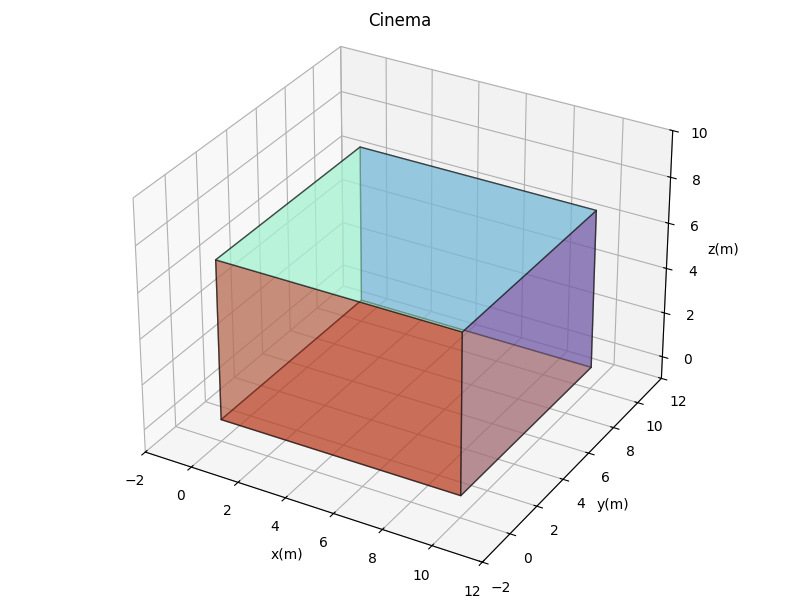

In [37]:
corners = np.array([[0, 0], [10, 0], [10, 10], [0, 10]]).T

room3D = pra.Room.from_corners(corners, fs=sr,
                              max_order=2, # 优化: 降低反射阶数，减少过度混响
                              materials=pra.Material(0.4, 0.1),
                              ray_tracing=True, 
                              air_absorption=True)
room3D.extrude(7.)#高度为7
help_view3D(room3D,title="Cinema")

### 2.设置声源

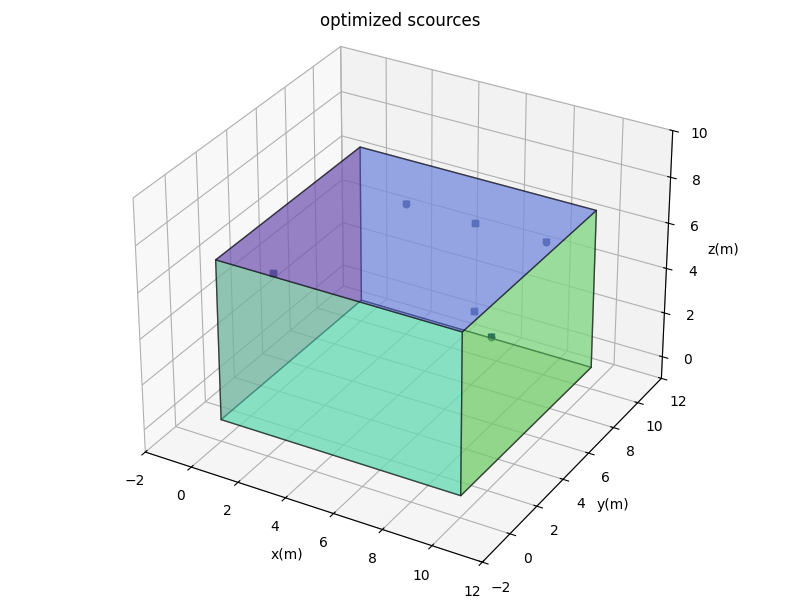

In [39]:
# 优化3: 重新设计声源布局，避免过多声源造成的相互干扰
# 主要使用前置声道和环绕声道
sources = np.array([
    # 主声道 (L, C, R)
    [2, 10, 5],    # 左声道
    [5, 10, 5],    # 中置声道  
    [8, 10, 5],    # 右声道
    
    # 环绕声道 (减少数量，避免过度混响)
    [0.5, 3, 5],   # 左环绕
    [9.5, 3, 5],   # 右环绕
    
    # 低频声道
    [5, 10, 1],    # 低音炮
])

# 优化4: 不同声源使用不同的音频信号或增益
for i, pos in enumerate(sources):
    if i < 3:  # 主声道使用原始信号
        room3D.add_source(pos, signal=audio)
    elif i < 5:  # 环绕声道使用降低增益的信号
        room3D.add_source(pos, signal=audio * 0.3)
    else:  # 低音炮使用低通滤波的信号
        # 简单的低通滤波
        from scipy import signal as scipy_signal
        sos = scipy_signal.butter(4, 200, btype='low', fs=sr, output='sos')
        filtered_audio = scipy_signal.sosfilt(sos, audio) * 0.5
        room3D.add_source(pos, signal=filtered_audio)
help_view3D(room3D, title="optimized scources")

### 3.设置听众位置

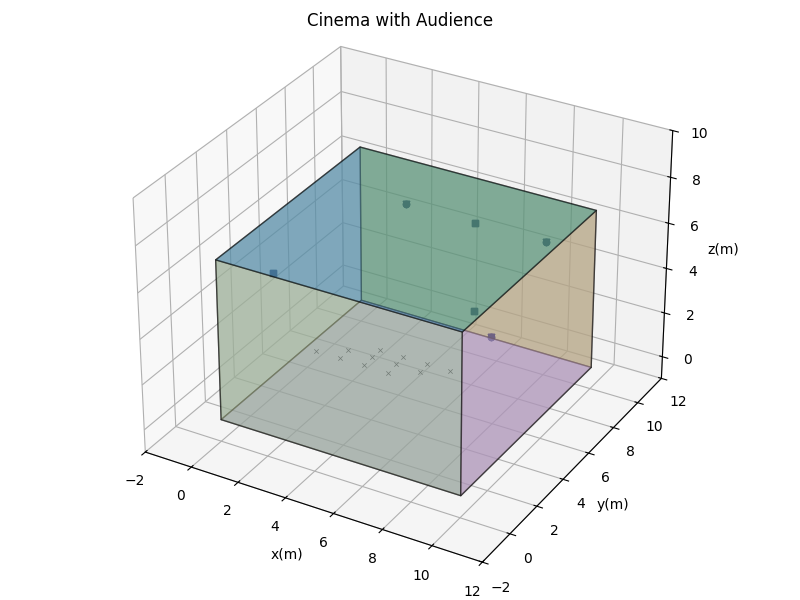

In [40]:
#座位位置
row_y = np.linspace(1., 5.5, 3)      # 3 排
col_x = np.linspace(3.5, 6.5, 4)      # 4 列
row_z  = np.linspace(3.6, 1.2, 3)    # 高度

audience = np.array([[x, y,  row_z[i]]        # 12 × 3
                     for i, y in enumerate(row_y)
                     for x in col_x] ).T   # → (3, 12)

# 把观众作为麦克风阵列加入房间 (可用于后续 RIR / 渲染)
mics = pra.MicrophoneArray(audience, room3D.fs)
room3D.add_microphone_array(mics)
help_view3D(room3D,title="Cinema with Audience")

### 4.计算RIR

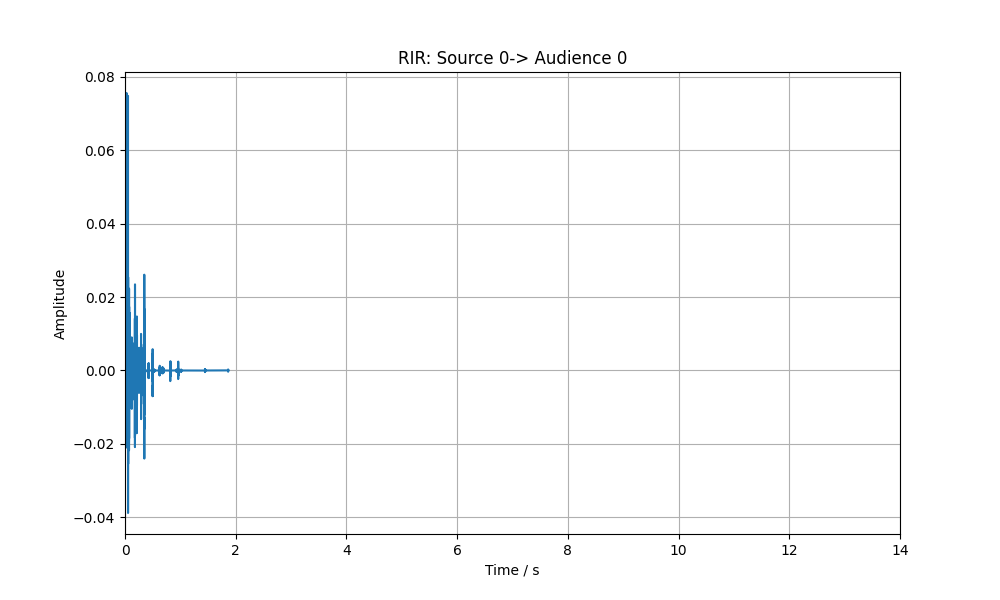

In [42]:
def help_view_RIR(room3D,source_index,mic_index):
    plt.figure(figsize=(10, 6))
    rir = room3D.rir[mic_index][source_index]
    plt.plot(np.arange(len(rir)) / room3D.fs, rir)
    plt.xlabel("Time / s"); plt.ylabel("Amplitude")
    plt.title(f"RIR: Source {0}-> Audience {0}")
    plt.grid(True)
    plt.xlim(0,14)
    plt.show()

room3D.set_ray_tracing(
    n_rays=2000,           # 减少射线数量
    receiver_radius=0.25,   # 稍微减小接收半径
    energy_thres=1e-4,     # 提高能量阈值，过滤弱反射
    hist_bin_size=64/sr,   # 减小时间分辨率
    #time_thres=0.5         # 设置时间阈值，截断过长的混响尾巴
)
room3D.compute_rir()
help_view_RIR(room3D,source_index =0,mic_index =0)

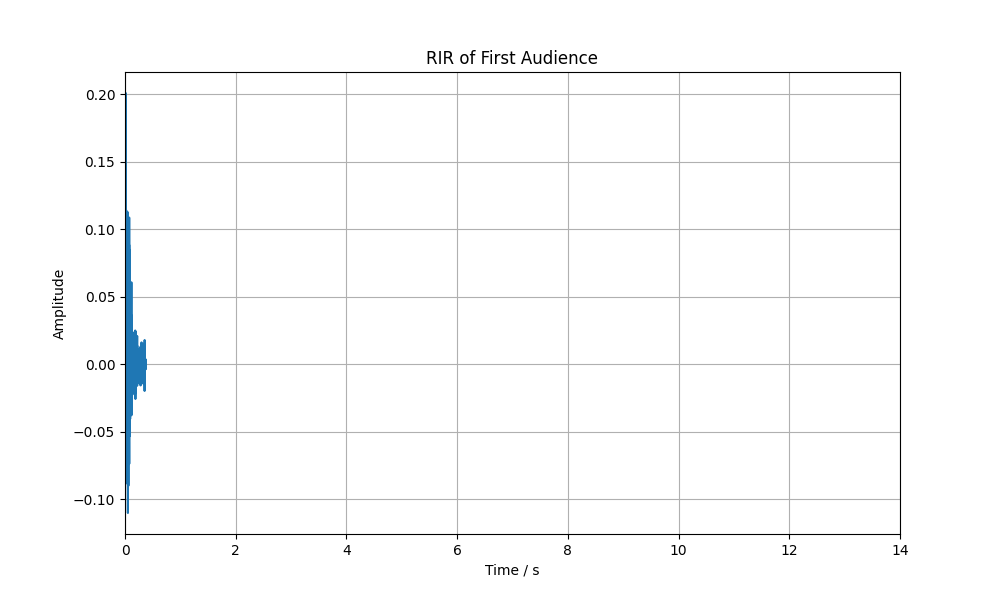

In [29]:
def pad_center(arr: np.ndarray, target_len: int) -> np.ndarray:
    """把 1-D 数组 arr 居中放进目标长度数组，左右补零。"""
    out = np.zeros(target_len, dtype=arr.dtype)
    offset = (target_len - len(arr)) // 2          # 左边留多少空位
    out[offset: offset + len(arr)] = arr
    return out

mic_id   = 0                     # 选第 1 位观众
n_src    = room3D.n_sources      # ← 这里就是 10
max_len  = max(len(room3D.rir[mic_id][s]) for s in range(n_src))

stacked = np.stack([
    pad_center(room3D.rir[mic_id][s], max_len)  # 每条都补到 max_len
    for s in range(n_src)
])

rir_sum = stacked.sum(axis=0)    # (n_src, max_len) → (max_len,)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(rir_sum)) / room3D.fs, rir_sum)
plt.xlabel("Time / s"); plt.ylabel("Amplitude")
plt.title(f"RIR of First Audience")
plt.grid(True)
plt.xlim(0,14)
plt.show()


In [43]:
room3D.simulate()
k = 6                             #k+1位听众
heard = room3D.mic_array.signals[k]   # 1-D numpy array
sf.write(f"wavs/optimized_audience{k+1}_in_cinema.wav", heard, room3D.fs)